In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load Dataset yang telah dipreproses

In [2]:
df = pd.read_csv('preprocessed_data.csv')

In [3]:
df

,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90
0,2010,0.076819,-0.904193,0.741152,0.288308,0.337940,-0.297278,0.797386,-0.649932,1.325580,...,-0.427372,-0.408894,0.492909,0.302912,-0.123721,-0.216511,1.178854,-0.369440,-0.173473,0.135820
1,2001,-0.429554,-1.654935,1.312589,0.430215,-2.083243,0.040902,0.959263,0.093997,-1.291260,...,0.757238,1.208850,-0.229178,-0.672345,0.188183,-0.282043,0.347996,0.162037,-0.060835,0.638719
2,2005,-0.177294,-0.891164,0.705829,0.581468,0.616893,-0.919390,0.579650,-0.656201,-0.889759,...,3.574417,0.006884,-0.269840,-0.959666,-1.780674,-0.601864,-1.056852,-1.086172,-0.843883,1.955740
3,2010,0.531816,-0.191198,-0.069069,0.337493,0.233309,-0.023601,1.303912,0.152492,0.986142,...,-0.783878,-0.273014,0.132765,0.655181,-0.172479,-0.129738,-0.109947,-0.025126,-0.770963,-0.547918
4,1964,-0.135163,0.778126,-0.673802,-1.047111,-0.095860,0.441310,-0.541030,-0.806848,-0.752516,...,-0.550894,0.949067,-0.241852,-0.074385,0.709859,-0.025401,-0.524856,-0.459015,0.132285,-0.135906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515340,2008,-0.031053,0.364042,-0.854716,-0.233855,-0.686712,0.708938,-0.527178,-0.075540,0.565912,...,0.464362,-0.244759,0.424390,-0.789137,1.344351,1.427555,0.699331,0.149233,0.742730,-0.480874
515341,1995,-1.397122,-0.475818,-1.065135,0.032593,0.337258,0.362462,-0.030867,0.756624,-0.298408,...,-1.006462,-0.374292,-1.252242,-1.657304,0.433203,0.371469,-3.601079,0.040447,0.905788,-2.827455
515342,2002,0.597608,-0.243860,0.112902,-0.103160,-0.928364,0.016888,0.117403,-0.426673,1.578736,...,-0.317836,-0.543074,-0.166695,0.189143,-0.607744,0.386116,0.251579,0.242116,-0.335300,-0.149496
515343,2007,0.382229,0.845620,-0.667609,0.978896,0.000815,-0.502829,0.358084,2.566696,-0.774890,...,-0.504946,-1.534973,-0.670947,-2.593401,-1.695578,1.741590,2.084436,1.430435,1.174769,0.300561


In [4]:
import tensorflow as tf

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l1_l2
import numpy as np

## Membuat Model dengan TensorFlow

### Persiapan Data dan Pembuatan Model Neural Network

Pada bagian ini, kita akan:
1. **Split data** menjadi training, validation, dan test set
2. **Membuat arsitektur neural network** dengan multiple hidden layers yang terdiri dari:
   - **5 hidden layers** dengan neuron yang menurun secara bertahap (512 → 256 → 128 → 64 → 32)
   - **Activation function ReLU** untuk semua hidden layers dan linear untuk output layer
   - **L1/L2 regularization** pada setiap layer untuk mencegah overfitting
3. **Menerapkan regularization techniques**:
   - **Dropout layers** dengan rate yang bervariasi (0.1-0.4) untuk mencegah overfitting
   - **BatchNormalization** setelah setiap dense layer untuk stabilitas training
   - **Weight decay** pada optimizer AdamW
4. **Menggunakan advanced optimization**:
   - **AdamW optimizer** dengan learning rate 0.001 dan weight decay
   - **Learning rate scheduler** yang menurunkan learning rate secara bertahap
   - **EarlyStopping** dan **ReduceLROnPlateau** callbacks untuk training yang optimal

In [ ]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_scaled = X_train.values
X_val_scaled = X_val.values
X_test_scaled = X_test.values

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 30:
        return lr * 0.95
    else:
        return lr * 0.9

model = Sequential([
    Dense(512, input_shape=(X_train_scaled.shape[1],), activation='relu',
          kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(1, activation='linear')
])

optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)

model.compile(optimizer=optimizer, 
              loss='mse', 
              metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, verbose=1),
    LearningRateScheduler(lr_scheduler, verbose=1)
]

model.summary()

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-repo-ray\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        46,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,153 (879.50 KB)

 Trainable params: 223,169 (871.75 KB)

 Non-trainable params: 1,984 (7.75 KB)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 3332583.5000 - mae: 1807.5823 - val_loss: 481672.3750 - val_mae: 693.9315 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 194724.0000 - mae: 376.8846 - val_loss: 176.9782 - val_mae: 11.5763 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 13987.2393 - mae: 93.2780 - val_loss: 144.2785 - val_mae: 10.3358 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 13861.9795 - mae: 92.7528 - val_loss: 119.8102 - val_mae: 9.1505 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate t

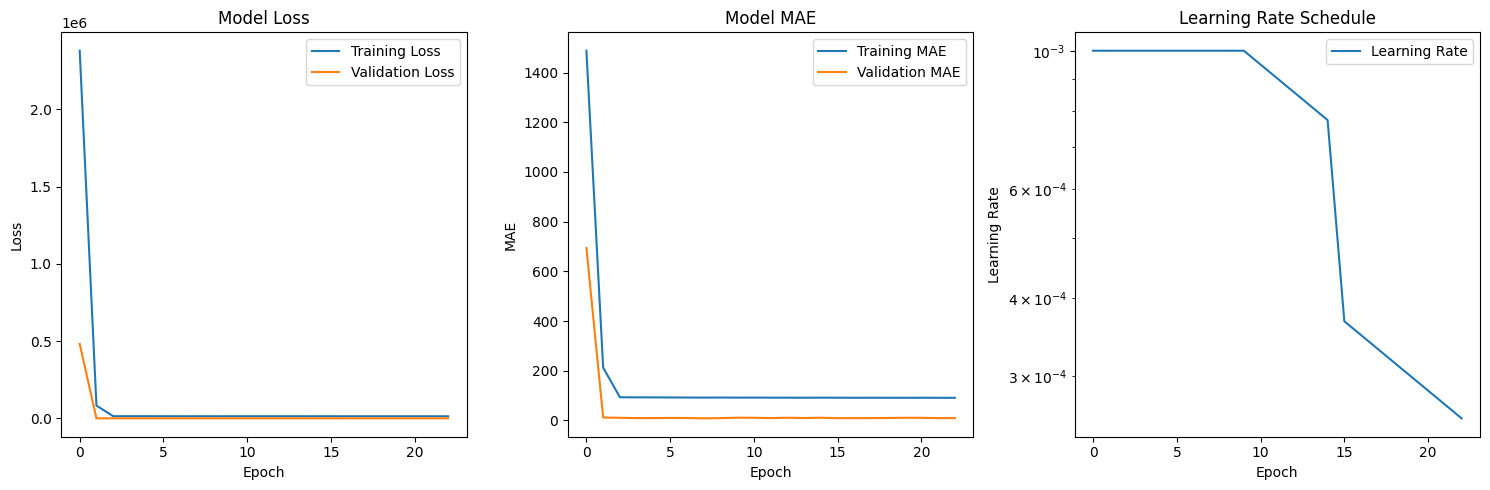

3221/3221 ━━━━━━━━━━━━━━━━━━━━ 2s 607us/step

Test Results:
RMSE: 10.5771
R²: 0.0629
MSE: 111.8749


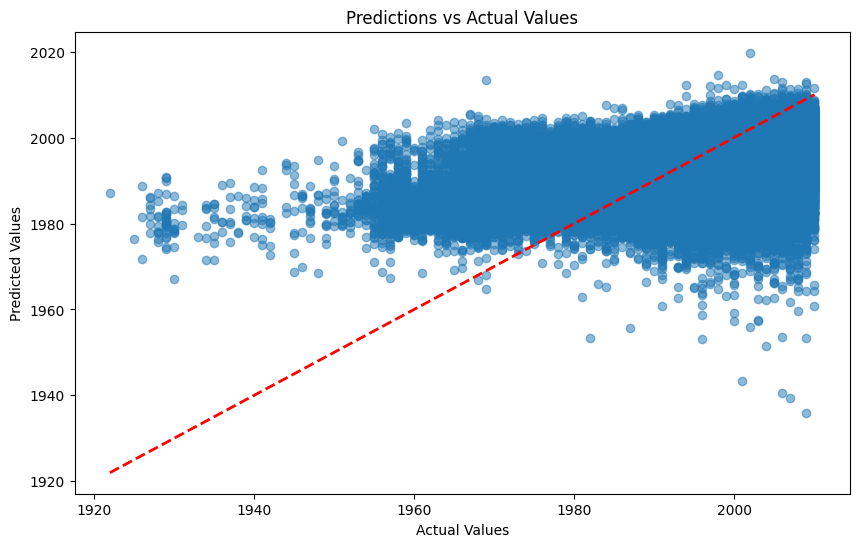

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['learning_rate'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()

y_pred = model.predict(X_test_scaled)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

print(f"\nTest Results:")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²: {test_r2:.4f}")
print(f"MSE: {test_mse:.4f}")


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred.flatten(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.show()

### Hasil Model 1:

- Test Results:
    - RMSE: 10.5771
    - R²: 0.0629
    - MSE: 111.8749

1. berdasarkan RMSE, R2, dan MSE, hasil masih kurang bagus.
2. Berdasarkan plotting Predictions vs ActualValues, mungkin terjadi underfitting

Pada model selanjutnya akan dicoba StandardScaling pada variabel target, dan menurunkan nilai Dropout

In [7]:
df = pd.read_csv('preprocessed_data.csv')

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_scaled = X_train.values
X_val_scaled = X_val.values
X_test_scaled = X_test.values

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.values.reshape(-1, 1)).flatten()

print(f"Feature shape: {X_train_scaled.shape}")
print(f"Target range before scaling: {y_train.min():.2f} to {y_train.max():.2f}")
print(f"Target range after scaling: {y_train_scaled.min():.2f} to {y_train_scaled.max():.2f}")

model = Sequential([
    Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1), 
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.05), 
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    
    Dense(1, activation='linear')
])

optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)

model.compile(optimizer=optimizer, 
              loss='mse', 
              metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)
]

model.summary()

print("\nTraining model...")
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\nMaking predictions...")
y_pred_scaled = model.predict(X_test_scaled, verbose=0)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()



Feature shape: (329820, 90)
Target range before scaling: 1922.00 to 2011.00
Target range after scaling: -6.99 to 1.15


c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-repo-ray\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,481 (267.50 KB)

 Trainable params: 67,521 (263.75 KB)

 Non-trainable params: 960 (3.75 KB)


Training model...
Epoch 1/100
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.8625 - mae: 0.6599 - val_loss: 0.6594 - val_mae: 0.5588 - learning_rate: 0.0010
Epoch 2/100
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6653 - mae: 0.5673 - val_loss: 0.6441 - val_mae: 0.5539 - learning_rate: 0.0010
Epoch 3/100
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6509 - mae: 0.5588 - val_loss: 0.6367 - val_mae: 0.5563 - learning_rate: 0.0010
Epoch 4/100
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6362 - mae: 0.5520 - val_loss: 0.6276 - val_mae: 0.5477 - learning_rate: 0.0010
Epoch 5/100
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6256 - mae: 0.5467 - val_loss: 0.6240 - val_mae: 0.5502 - learning_rate: 0.0010
Epoch 6/100
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6173 - mae: 0.5434 - val_loss: 0.6216 - val_mae: 0.5427 - learning_rate: 0.0010
Epoch 7/100
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6107 - mae: 0.5400 - val_loss: 0.6174 - val_m


Test Results (Original Scale):
RMSE: 8.5002
R²: 0.3948
MSE: 72.2532


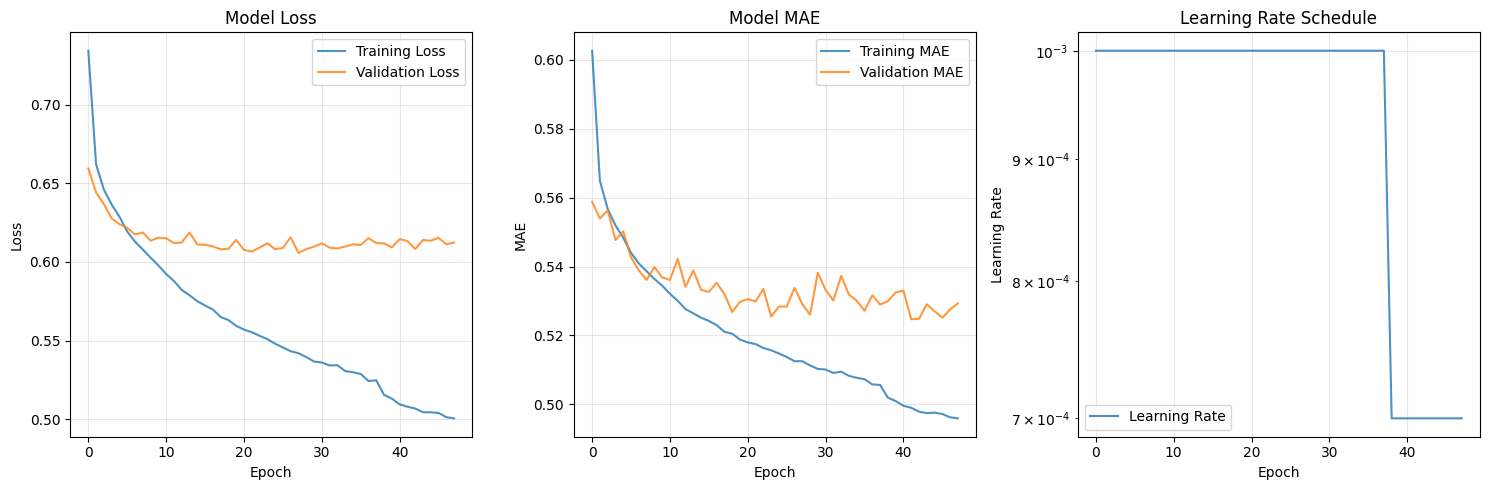

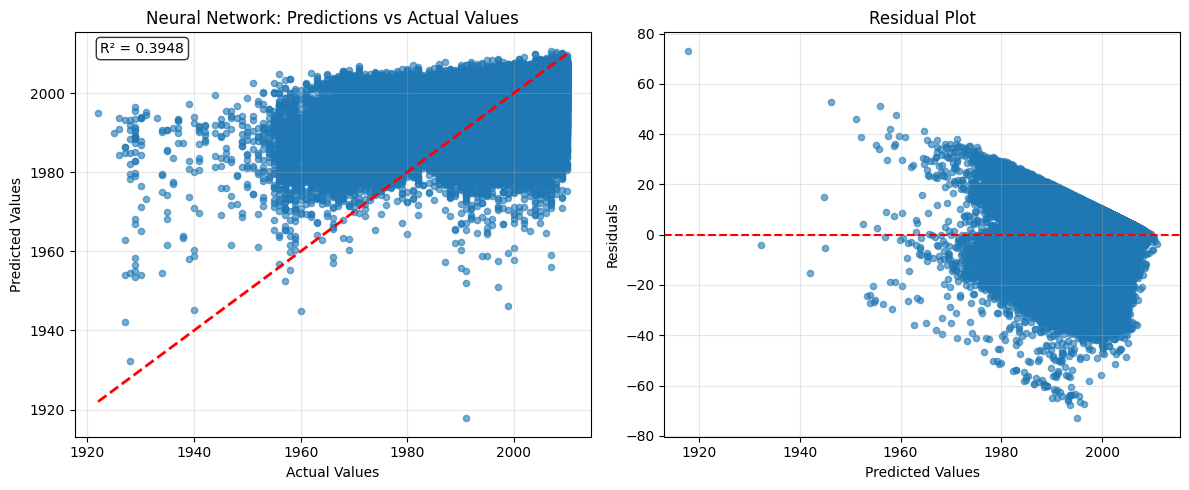

In [8]:
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

print(f"\nTest Results (Original Scale):")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²: {test_r2:.4f}")
print(f"MSE: {test_mse:.4f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', alpha=0.8)
plt.plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE', alpha=0.8)
plt.plot(history.history['val_mae'], label='Validation MAE', alpha=0.8)
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history.history['learning_rate'], label='Learning Rate', alpha=0.8)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Neural Network: Predictions vs Actual Values')
plt.grid(True, alpha=0.3)

plt.text(0.05, 0.95, f'R² = {test_r2:.4f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Hasil model 2:
Hasil model setelah dilakukan standard scaling pada variabel target:
- Test Results (Original Scale):
    - RMSE: 8.5002
    - R²: 0.3948
    - MSE: 72.2532

### Dibandingkan model terbaik (XGBoost) pada saat UTS:

- XGBoost:
    - R2: 0.3332 
- MLP Model:
    - R2: 0.3948
  

### Model MLP lebih baik dibanding XGBoost, dan dapat memprediksi regresi lebih akurat

### Metrik terbaik untuk pengukuran performa model

**RMSE (Root Mean Square Error):**
- Mengukur rata-rata kesalahan prediksi dalam satuan yang sama dengan target
- Semakin kecil nilai RMSE, semakin baik model
- Sensitif terhadap outlier karena menggunakan kuadrat dari error

**R² (R-squared/Coefficient of Determination):**
- Mengukur seberapa baik model menjelaskan variasi dalam data
- Rentang nilai 0-1, dimana 1 adalah prediksi sempurna
- Semakin tinggi nilai R², semakin baik model
- Mudah diinterpretasi sebagai persentase variasi yang dijelaskan

**MSE (Mean Square Error):**
- Rata-rata dari kuadrat kesalahan prediksi
- Dalam satuan kuadrat dari target, sehingga sulit diinterpretasi
- Semakin kecil nilai MSE, semakin baik model

**Metrik terbaik: R²**
- Paling mudah diinterpretasi (0-100% variasi yang dijelaskan)
- Tidak bergantung pada satuan data
- Standar industri untuk evaluasi model regresi
- Memungkinkan perbandingan langsung antar model yang berbeda